In [2]:
import pandas as pd
import json
import os
import subprocess
import bibtexparser
from tqdm import tqdm
import re
from flair.data import Sentence
from fuzzywuzzy import fuzz

In [ ]:
SPLITT_PATTERN = re.compile("; see |; | . See also | .See also |. See |, see")

def file_finder(file_str: str) -> str:
    """
    This function takes a file name and returns the path to the file in the all_data_articles.
    """
    title_doi = "../data/titles_doi.csv"
    folder_path = "../all_data_articles"

    try:
        # extract the doi from the file name
        doi = file_str.split("_")[-1].split(".")[0]

        # find the row in the csv file where the doi column ends with the doi
        df = pd.read_csv(title_doi)
        doi_row = df[df["DOI"].str.endswith(doi)]

        # extract the title from the row
        title_json = doi_row["Title"].values[0].replace(" ", "_") + ".json"
        title_json = "".join(
            e for e in title_json if e.isalnum() or e == "-" or e == "_" or e == "."
        )

        for filename in os.listdir(folder_path):
            if filename.endswith(".json") and filename.startswith(
                title_json[: int(len(title_json) / 3)]
            ):
                return filename

    except Exception as e:
        raise FileNotFoundError(f"File not found for {file_str}") from e

def load_annotations(file_str: str) -> pd.DataFrame:
    """
    This function takes a file name and returns the annotations from the file.
    And also replaces missing values with None.
    """
    folder_path = "../data/annotated"

    file_path = os.path.join(folder_path, file_str)
    df = pd.read_excel(file_path)

    # replace missing values with None
    df = df.where(pd.notnull(df), None)

    # replace values marked with nan with None
    df = df.replace("nan", None)

    return df


def format_author_name(name):
    # TODO: probably need to handle more cases
    if name is None:
        return None
    if " and " in name:
        # Handle multiple authors
        authors = name.split(" and ")
        formatted_authors = [format_author_name(author) for author in authors]
        return " and ".join(formatted_authors)
    else:
        parts = name.split()
        # Handle case where there is a middle initial
        if len(parts) == 3:
            return f"{parts[1]}, {parts[0]} {parts[2]}"
        # Handle case where there is no middle initial
        elif len(parts) == 2:
            return f"{parts[1]}, {parts[0]}"
        else:
            return name


def df_to_triplets(df: pd.DataFrame, format_author=True) -> set:
    """
    This function takes a dataframe and returns a set of triplets.
    """
    triplets = set()
    for i in range(len(df)):
        if format_author:
            triplet = (
                df.iloc[i]["Footnote"],
                format_author_name(df.iloc[i]["Authors"]),
                df.iloc[i]["Title"],
            )
        else:
            triplet = (
                df.iloc[i]["Footnote"],
                df.iloc[i]["Authors"],
                df.iloc[i]["Title"],
            )
        triplets.add(triplet)
    return triplets


def dict_to_triplets(extraction: dict) -> set:
    """
    Converts a dictionary of footnotes to a set of triplets
    """
    triplets = set()

    for number, references in extraction.items():
        for reference in references:
            author = reference[0]
            title = reference[1]

            if author == "":
                author = None

            if title == "":
                title = None

            triplets.add((int(number), author, title))

    return triplets


def information_extraction(
    file_path: str, path="../all_data_articles", path_to_anystyle="."
) -> set:
    """
    This function takes a file path and returns a set of triplets.
    """
    file_path = os.path.join(path, file_path)
    article = json.load(open(file_path, "r"))
    extraction = {}

    prev_footnote = None

    for number, footnote in tqdm(article["footnotes"].items()):

        # If the footnote is ibid, use the previous footnote
        if footnote.startswith("Ibid"):
            # do not fully replace ibid with previous footnote but rather prepend it since there might be other references after ibid
            footnote = prev_footnote + "; " + footnote.lstrip("Ibid. ")

        # Store the footnote for the next iteration
        prev_footnote = footnote

        references = SPLITT_PATTERN.split(footnote)

        author_title_list = []

        for reference in references:

            command = [
                "ruby",
                os.path.join(path_to_anystyle, "anystyle.rb"),
                str(reference).strip(),
            ]
            bibtex = subprocess.run(command, stdout=subprocess.PIPE, text=True).stdout
            parsed_bibtex = bibtexparser.loads(bibtex).entries

            if parsed_bibtex:
                parsed_bibtex = parsed_bibtex[0]
            else:
                # print(f"No valid BibTeX entry found in: {bibtex}, set to empty dict")
                parsed_bibtex = {}

            if "note" in parsed_bibtex:
                continue

            # Extract title and author
            title = parsed_bibtex.get("title", parsed_bibtex.get("booktitle", None))
            author = parsed_bibtex.get("author", parsed_bibtex.get("editor", None))

            if author is not None or title is not None:
                # Append author and title pair to the list
                author_title_list.append([author, title])

        # Store the list in the extraction dictionary with the footnote number as the key
        extraction[number] = author_title_list

    return dict_to_triplets(extraction)


def calculate_scores(triplets, extractions):
    TP = len(triplets & extractions)  # Intersection of triplets and extractions
    FP = len(extractions - triplets)  # Elements in extractions but not in triplets
    FN = len(triplets - extractions)  # Elements in triplets but not in extractions

    recall = TP / (TP + FN) if TP + FN != 0 else 0
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    f_score = (
        2 * (precision * recall) / (precision + recall)
        if precision + recall != 0
        else 0
    )

    return recall, precision, f_score


def calculate_similarity(str1, str2):
    # return SequenceMatcher(None, str1, str2).ratio()

    # https://pypi.org/project/fuzzywuzzy/
    # TODO: could also use token_sort_ratio since token_set_ratio might be too generous
    return fuzz.token_set_ratio(str1, str2) / 100


def evaluate_extraction(set1, set2, threshold=0.95):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for triplet1 in set1:
        footnote1, author1, title1 = triplet1
        author1 = author1 if author1 is not None else ""
        title1 = title1 if title1 is not None else ""
        concat_str1 = str(author1) + " " + str(title1)
        found_match = False

        for triplet2 in set2:
            footnote2, author2, title2 = triplet2
            author2 = author2 if author2 is not None else ""
            title2 = title2 if title2 is not None else ""
            concat_str2 = str(author2) + " " + str(title2)

            # Check for footnote number and similarity
            if (
                footnote1 == footnote2
                and calculate_similarity(concat_str1, concat_str2) >= threshold
            ):
                found_match = True
                break

        if found_match:
            true_positives += 1
        else:
            false_negatives += 1

    false_positives = len(set2) - true_positives

    precision = (
        true_positives / (true_positives + false_positives)
        if (true_positives + false_positives) > 0
        else 0
    )
    recall = (
        true_positives / (true_positives + false_negatives)
        if (true_positives + false_negatives) > 0
        else 0
    )
    f_score = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0
        else 0
    )

    return precision, recall, f_score


# TODO: implement a simple approach with a just regrex to extract the author and title, and a simple split with ";"


def extract_citations(file_path: str, path="../all_data_articles") -> set:
    file_path = os.path.join(path, file_path)
    article = json.load(open(file_path, "r"))
    citations = set()
    prev_footnote = None

    for footnote_number, footnote_text in tqdm(article["footnotes"].items()):
        # If the footnote is ibid, use the previous footnote
        if footnote_text.startswith("Ibid"):
            footnote_text = prev_footnote

        prev_footnote = footnote_text

        # Split the footnote into individual citations
        individual_citations = SPLITT_PATTERN.split(footnote_text)

        for citation_text in individual_citations:
            # Regular expression to extract authors and titles
            # TODO: try a better pattern
            pattern = re.compile(r"^(.+?),\s+(.+?)[,|(]")

            match = pattern.match(citation_text)

            if match:
                author = match.group(1)
                title = match.group(2)
                citations.add((int(footnote_number), author, title))
    return citations


def tagger_information_extraction(
    file_path: str, tagger, path="../all_data_articles"
) -> set:
    file_path = os.path.join(path, file_path)
    article = json.load(open(file_path, "r"))

    citations = set()
    prev_footnote = None

    for footnote_number, footnote_text in tqdm(article["footnotes"].items()):
        # If the footnote is ibid, use the previous footnote
        if footnote_text.startswith("Ibid"):
            footnote_text = prev_footnote

        prev_footnote = footnote_text

        # Split the footnote into individual citations
        individual_citations = SPLITT_PATTERN.split(footnote_text)

        for citation_text in individual_citations:

            author = None

            sentence = Sentence(citation_text)
            tagger.predict(sentence)
            for span in sentence.get_spans("ner"):
                if span.tag == "PERSON" or span.tag == "ORG":
                    if author is None:
                        author = span.text
                    else:
                        author += "and " + span.text
                if span.tag == "WORK_OF_ART":
                    citations.add((int(footnote_number), author, span.text))
                    author = None

    return citations

In [13]:
evaluation = {}

In [14]:
path_annotations = "../data/annotated"
scores = {"exact": {}, "similarity": {}}

for filename in os.listdir(path_annotations):
    print(filename)
    title_json = file_finder(filename)
    df = load_annotations(filename)
    triplets = df_to_triplets(df, format_author=True)
    extraction = information_extraction(title_json)
    recall, precision, f_score = evaluate_extraction(triplets, extraction, threshold=0.9)
    exact_recall, exact_precision, exact_f_score = calculate_scores(triplets, extraction)
    scores["similarity"][filename] = {"recall": recall, "precision": precision, "f_score": f_score}
    scores["exact"][filename] = {"recall": exact_recall, "precision": exact_precision, "f_score": exact_f_score}
    print("\n")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F-Score: {f_score}")
    print("-"* 50)
    print("\n")
    #break

evaluation["anystyle"] = scores 

Labels - https___doi.org_10.1093_ehr_cew052.xlsx


100%|██████████| 148/148 [01:12<00:00,  2.04it/s]




Recall: 0.8288770053475936
Precision: 0.7989690721649485
F-Score: 0.8136482939632547
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_cead107.xlsx


100%|██████████| 124/124 [01:27<00:00,  1.42it/s]




Recall: 0.6958762886597938
Precision: 0.6887755102040817
F-Score: 0.6923076923076924
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_cead080.xlsx


100%|██████████| 133/133 [01:16<00:00,  1.75it/s]




Recall: 0.8852459016393442
Precision: 0.8901098901098901
F-Score: 0.8876712328767122
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_ceac260.xlsx


100%|██████████| 175/175 [01:41<00:00,  1.72it/s]




Recall: 0.6266666666666667
Precision: 0.6322869955156951
F-Score: 0.6294642857142858
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_cead065.xlsx


100%|██████████| 142/142 [01:41<00:00,  1.40it/s]




Recall: 0.7644628099173554
Precision: 0.8295964125560538
F-Score: 0.7956989247311829
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_cead004.xlsx


100%|██████████| 171/171 [01:22<00:00,  2.08it/s]




Recall: 0.8910891089108911
Precision: 0.8294930875576036
F-Score: 0.8591885441527447
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_cead103.xlsx


 21%|██        | 24/115 [00:19<01:10,  1.29it/s]Entry type thesis not standard. Not considered.
Entry type thesis not standard. Not considered.
100%|██████████| 115/115 [01:25<00:00,  1.34it/s]




Recall: 0.766497461928934
Precision: 0.7512437810945274
F-Score: 0.7587939698492462
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_ceab280.xlsx


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]



Recall: 0.6890756302521008
Precision: 0.34893617021276596
F-Score: 0.46327683615819204
--------------------------------------------------


In [15]:
evaluation

{'anystyle': {'exact': {'Labels - https___doi.org_10.1093_ehr_cew052.xlsx': {'recall': 0.25773195876288657,
    'precision': 0.26737967914438504,
    'f_score': 0.2624671916010499},
   'Labels - https___doi.org_10.1093_ehr_cead107.xlsx': {'recall': 0.12244897959183673,
    'precision': 0.12371134020618557,
    'f_score': 0.12307692307692308},
   'Labels - https___doi.org_10.1093_ehr_cead080.xlsx': {'recall': 0.2087912087912088,
    'precision': 0.20765027322404372,
    'f_score': 0.20821917808219176},
   'Labels - https___doi.org_10.1093_ehr_ceac260.xlsx': {'recall': 0.16143497757847533,
    'precision': 0.16,
    'f_score': 0.16071428571428573},
   'Labels - https___doi.org_10.1093_ehr_cead065.xlsx': {'recall': 0.16143497757847533,
    'precision': 0.1487603305785124,
    'f_score': 0.15483870967741936},
   'Labels - https___doi.org_10.1093_ehr_cead004.xlsx': {'recall': 0.2903225806451613,
    'precision': 0.3118811881188119,
    'f_score': 0.30071599045346065},
   'Labels - https___d

In [17]:
path_annotations = "../data/annotated"

scores = {"exact": {}, "similarity": {}}

for filename in os.listdir(path_annotations):
    print(filename)
    title_json = file_finder(filename)
    df = load_annotations(filename)
    triplets = df_to_triplets(df, format_author=False)
    extraction = extract_citations(title_json)
    recall, precision, f_score = evaluate_extraction(triplets, extraction, threshold=0.9)
    exact_recall, exact_precision, exact_f_score = calculate_scores(triplets, extraction)
    scores["similarity"][filename] = {"recall": recall, "precision": precision, "f_score": f_score}
    scores["exact"][filename] = {"recall": exact_recall, "precision": exact_precision, "f_score": exact_f_score}
    print("\n")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F-Score: {f_score}")
    print("-"* 50)
    print("\n")

evaluation["regex"] = scores

Labels - https___doi.org_10.1093_ehr_cew052.xlsx


  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 176401.53it/s]




Recall: 0.7613636363636364
Precision: 0.6907216494845361
F-Score: 0.7243243243243243
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_cead107.xlsx


100%|██████████| 124/124 [00:00<00:00, 63041.66it/s]




Recall: 0.8430232558139535
Precision: 0.7397959183673469
F-Score: 0.7880434782608696
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_cead080.xlsx


100%|██████████| 133/133 [00:00<00:00, 194370.19it/s]




Recall: 0.8876404494382022
Precision: 0.8681318681318682
F-Score: 0.8777777777777778
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_ceac260.xlsx


100%|██████████| 175/175 [00:00<00:00, 175724.97it/s]



Recall: 0.8270042194092827
Precision: 0.8789237668161435
F-Score: 0.8521739130434782
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_cead065.xlsx



100%|██████████| 142/142 [00:00<00:00, 184622.18it/s]




Recall: 0.8325581395348837
Precision: 0.8026905829596412
F-Score: 0.817351598173516
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_cead004.xlsx


100%|██████████| 171/171 [00:00<00:00, 224343.44it/s]




Recall: 0.9947643979057592
Precision: 0.8755760368663594
F-Score: 0.9313725490196079
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_cead103.xlsx


100%|██████████| 115/115 [00:00<00:00, 129245.70it/s]




Recall: 0.8212290502793296
Precision: 0.7313432835820896
F-Score: 0.7736842105263159
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_ceab280.xlsx


100%|██████████| 100/100 [00:00<00:00, 178557.00it/s]




Recall: 0.8145161290322581
Precision: 0.4297872340425532
F-Score: 0.5626740947075209
--------------------------------------------------


In [19]:
path_annotations = "../data/annotated"
# load the NER tagger
tagger = Classifier.load('ner-ontonotes-large')

scores = {"exact": {}, "similarity": {}}

for filename in os.listdir(path_annotations):
    print(filename)
    title_json = file_finder(filename)
    df = load_annotations(filename)
    triplets = df_to_triplets(df, format_author=False)
    extraction = tagger_information_extraction(title_json, tagger=tagger)
    recall, precision, f_score = evaluate_extraction(triplets, extraction, threshold=0.9)
    exact_recall, exact_precision, exact_f_score = calculate_scores(triplets, extraction)
    scores["similarity"][filename] = {"recall": recall, "precision": precision, "f_score": f_score}
    scores["exact"][filename] = {"recall": exact_recall, "precision": exact_precision, "f_score": exact_f_score}
    print("\n")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F-Score: {f_score}")
    print("-"* 50)
    print("\n")

evaluation["tagger"] = scores

2024-01-06 15:32:53,177 SequenceTagger predicts: Dictionary with 76 tags: <unk>, O, B-CARDINAL, E-CARDINAL, S-PERSON, S-CARDINAL, S-PRODUCT, B-PRODUCT, I-PRODUCT, E-PRODUCT, B-WORK_OF_ART, I-WORK_OF_ART, E-WORK_OF_ART, B-PERSON, E-PERSON, S-GPE, B-DATE, I-DATE, E-DATE, S-ORDINAL, S-LANGUAGE, I-PERSON, S-EVENT, S-DATE, B-QUANTITY, E-QUANTITY, S-TIME, B-TIME, I-TIME, E-TIME, B-GPE, E-GPE, S-ORG, I-GPE, S-NORP, B-FAC, I-FAC, E-FAC, B-NORP, E-NORP, S-PERCENT, B-ORG, E-ORG, B-LANGUAGE, E-LANGUAGE, I-CARDINAL, I-ORG, S-WORK_OF_ART, I-QUANTITY, B-MONEY
Labels - https___doi.org_10.1093_ehr_cew052.xlsx


100%|██████████| 148/148 [00:22<00:00,  6.71it/s]




Recall: 0.7962085308056872
Precision: 0.865979381443299
F-Score: 0.8296296296296297
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_cead107.xlsx


100%|██████████| 124/124 [00:27<00:00,  4.53it/s]




Recall: 0.7055837563451777
Precision: 0.7091836734693877
F-Score: 0.707379134860051
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_cead080.xlsx


100%|██████████| 133/133 [00:21<00:00,  6.17it/s]




Recall: 0.8323699421965318
Precision: 0.7912087912087912
F-Score: 0.8112676056338028
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_ceac260.xlsx


100%|██████████| 175/175 [00:33<00:00,  5.29it/s]




Recall: 0.6890243902439024
Precision: 0.5067264573991032
F-Score: 0.5839793281653748
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_cead065.xlsx


100%|██████████| 142/142 [00:27<00:00,  5.10it/s]




Recall: 0.8031088082901554
Precision: 0.695067264573991
F-Score: 0.7451923076923076
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_cead004.xlsx


100%|██████████| 171/171 [00:27<00:00,  6.28it/s]




Recall: 0.7675675675675676
Precision: 0.6543778801843319
F-Score: 0.7064676616915423
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_cead103.xlsx


100%|██████████| 115/115 [00:25<00:00,  4.59it/s]




Recall: 0.695906432748538
Precision: 0.5920398009950248
F-Score: 0.6397849462365591
--------------------------------------------------


Labels - https___doi.org_10.1093_ehr_ceab280.xlsx


100%|██████████| 100/100 [00:17<00:00,  5.56it/s]



Recall: 0.6783216783216783
Precision: 0.4127659574468085
F-Score: 0.5132275132275133
--------------------------------------------------


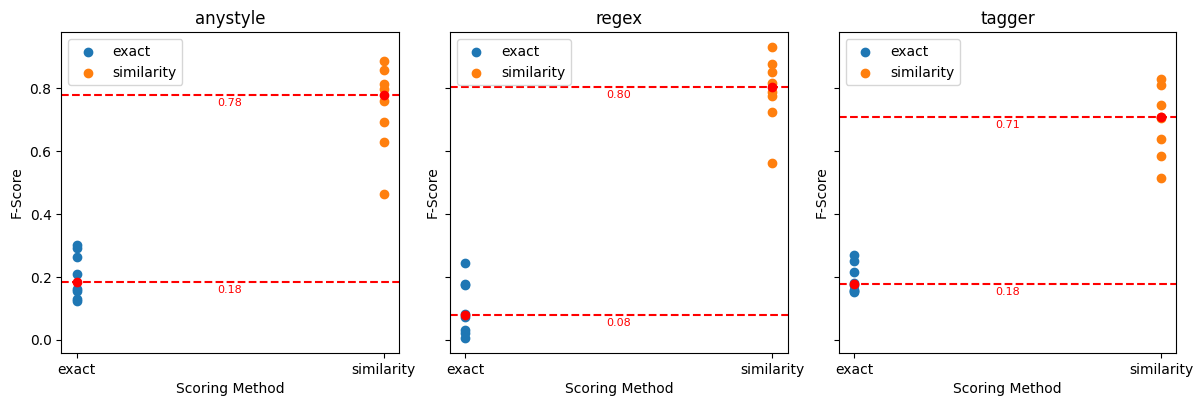

In [20]:
import numpy as np
import matplotlib.pyplot as plt

approaches = ["anystyle", "regex", "tagger"]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, approach in enumerate(approaches):
    exact_scores = evaluation[approach]["exact"]
    similarity_scores = evaluation[approach]["similarity"]
    
    filenames = exact_scores.keys()
    
    f_scores_exact = [exact_scores[filename]["f_score"] for filename in filenames]
    f_scores_similarity = [similarity_scores[filename]["f_score"] for filename in filenames]
        
    median_f_score_exact = np.median(f_scores_exact)
    median_f_score_similarity = np.median(f_scores_similarity)
    
    axs[i].scatter(["exact"] * len(f_scores_exact), f_scores_exact, label="exact")
    axs[i].scatter(["similarity"] * len(f_scores_similarity), f_scores_similarity, label="similarity")
    
    axs[i].scatter(["exact"], median_f_score_exact, color="red")
    axs[i].scatter(["similarity"], median_f_score_similarity, color="red")
    
    axs[i].axhline(median_f_score_exact, color="red", linestyle="--")
    axs[i].axhline(median_f_score_similarity, color="red", linestyle="--")
    
    axs[i].text(0.5, median_f_score_exact - 0.04, f"{median_f_score_exact:.2f}", ha="center", va="bottom", color="red", fontsize=8)
    axs[i].text(0.5, median_f_score_similarity - 0.04, f"{median_f_score_similarity:.2f}", ha="center", va="bottom", color="red", fontsize=8)

    axs[i].set_title(approach)
    axs[i].set_xlabel("Scoring Method")
    axs[i].set_ylabel("F-Score")
    axs[i].legend()

plt.tight_layout(pad=0.5)
plt.show()
